<a href="https://colab.research.google.com/github/danjokuuu/gpa-forecast-tracker/blob/main/Music_Genre_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Used: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

# Initializing Data


*   Importing files
*   Importing libraries
*   Inspecting



In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dataset_path = "/content/drive/MyDrive/Data/features_3_sec.csv"

Mounted at /content/drive


In [ ]:
import random
import os
import librosa
import IPython
import numpy as np
import pandas as pd
import keras as kr
import tensorflow as tf
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import librosa.display as lplt
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
dataset = pd.read_csv(dataset_path)
dataset.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [ ]:
dataset.label.value_counts().reset_index()

label  count
0      blues   1000
1       jazz   1000
2      metal   1000
3        pop   1000
4     reggae   1000
5      disco    999
6  classical    998
7     hiphop    998
8       rock    998
9    country    997

# Visualizing Data
Understanding the music samples visually using :

*   Frequency-Time Graph
*   Short-Time Fourier Transformation (STFT)
*   Beats Per Minute (BPM) boxplot



In [ ]:
# choosing an audio file to sample
audio_sample = "/content/drive/MyDrive/Data/genres_original/blues/blues.00000.wav"

# extracts a numpy array of the audio signal represented as an array of amplitude values, and the "sample rate" or numbers of samples of audio carried per second
audio_data, sample_rate = librosa.load(audio_sample)

# trimming the audio to exclude parts where the audio signal falls below a certain threshold (namely the beginning and ending)
audio_data, audio_trim = librosa.effects.trim(audio_data)

print(f"Sample rate is {sample_rate}")

Sample rate is 22050


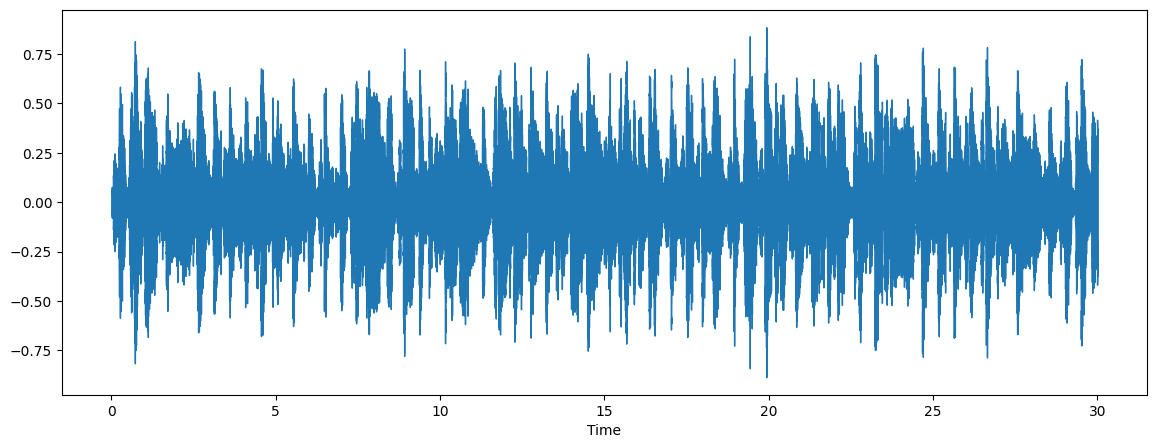

In [ ]:
# plotting a graph of the samples amlitude
plt.figure(figsize=(14, 5))
lplt.waveshow(audio_data, sr=sample_rate)
plt.show()

# playing the sample
IPython.display.Audio(audio_sample, rate=sample_rate)




---


*The Amplitude Spectrogram displays visually the percieved volume of the sample over time **with raw amplitude values**.*


<ipython-input-14-49e0ba691ecf>:5: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  lplt.specshow(stft, sr=sample_rate, x_axis="time", y_axis="hz",cmap="viridis")


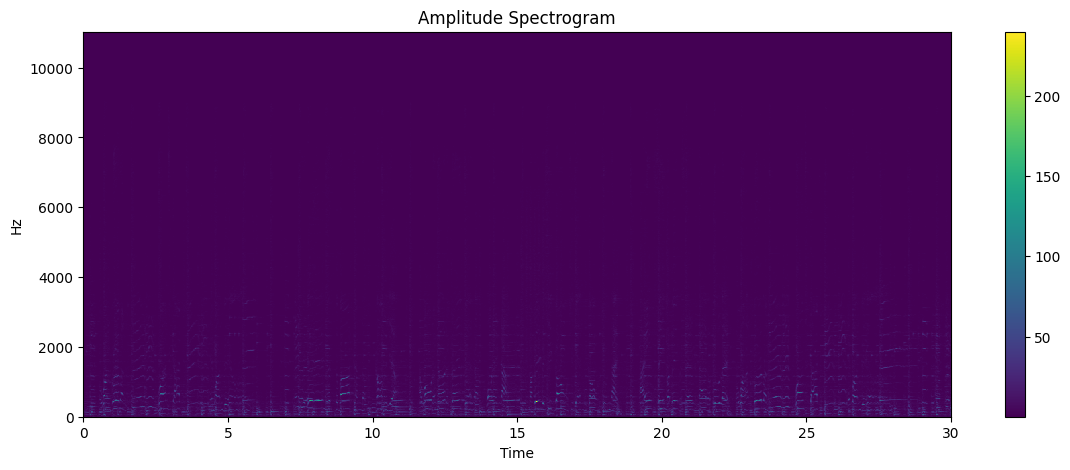

In [ ]:
# computing the STFT (short-time Fourier transform) of the audio data
stft = librosa.stft(audio_data, hop_length=512) # hop length controls the overlap between frames

plt.figure(figsize=(14, 5))
lplt.specshow(stft, sr=sample_rate, x_axis="time", y_axis="hz",cmap="viridis")
plt.colorbar()
plt.title("Amplitude Spectrogram")
plt.show()



---


*The Decibel Spectrogram displays visually the percieved volume of the sample over time **with logarithmic values**.*


<ipython-input-15-dff07e5f325c>:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  decibels = librosa.amplitude_to_db(stft, ref=np.max)


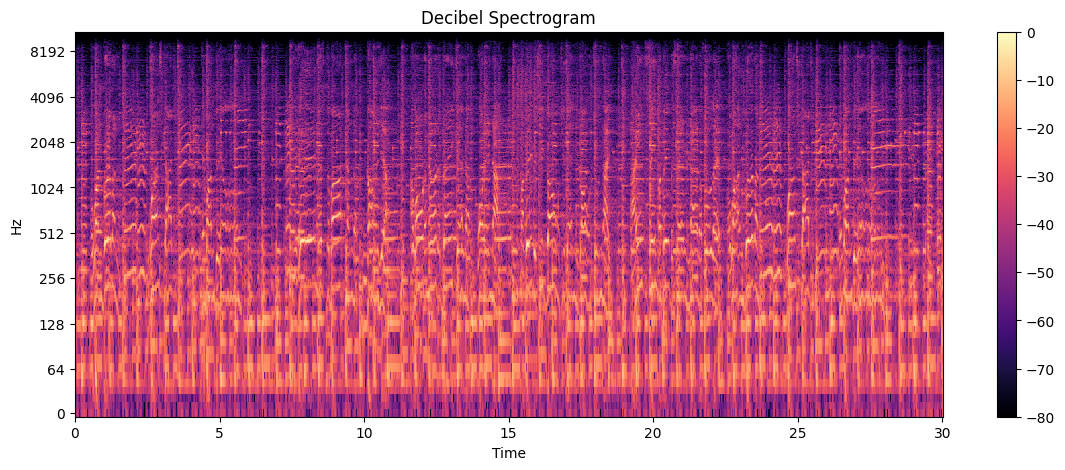

In [ ]:
# converts the amplitude to decibels
decibels = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(14, 5))
lplt.specshow(decibels, sr=sample_rate, x_axis="time", y_axis="log")
plt.colorbar()
plt.title("Decibel Spectrogram")
plt.show()

*Spectrogram converted to the mel scale to more accurately display audio and **better capture human pitch perception**.*

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

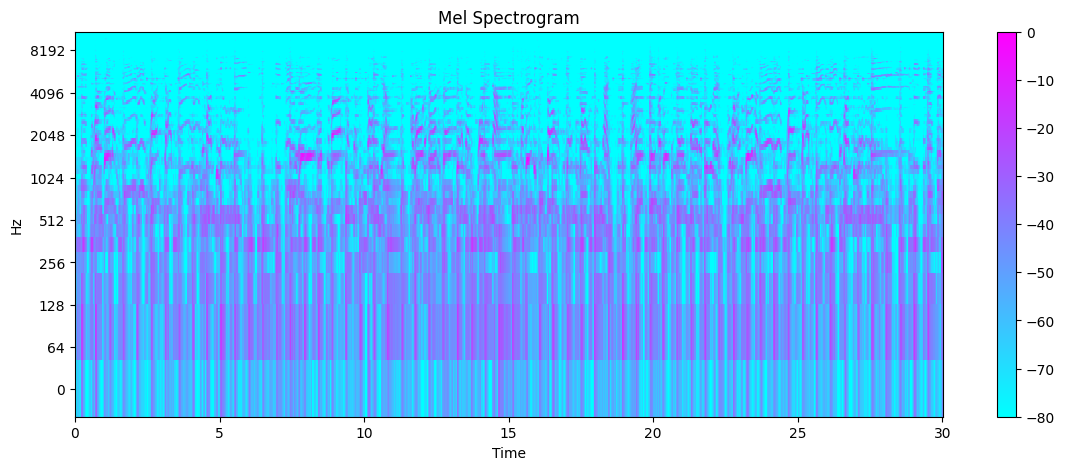

In [ ]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
mel_spectrogram_decibels = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(14, 5))
lplt.specshow(mel_spectrogram_decibels, sr=sample_rate, x_axis="time", y_axis="log", cmap="cool")
plt.colorbar()
plt.title("Mel Spectrogram")
plt

*BPM Boxplot giving a visual reprsentation of the Beats Per Minute within each Genre.*

<ipython-input-12-33477b646f79>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="tempo", data=dataset_cols, ax=axes, palette="pastel")


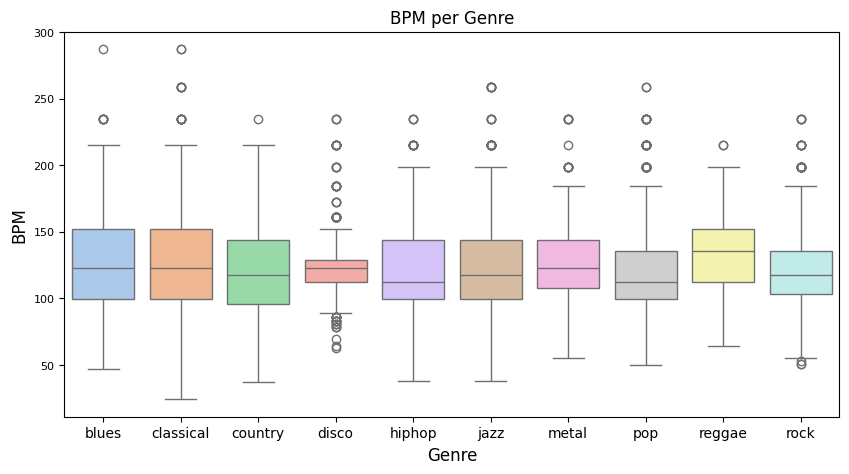

In [ ]:
# extracting the genre and bpm data respectively
dataset_cols = dataset[["label", "tempo"]]

# creating a figure and set of axes for plotting.
fig, axes = plt.subplots(figsize=(10, 5))

sns.boxplot(x="label", y="tempo", data=dataset_cols, ax=axes, palette="pastel")

plt.xticks(fontsize =10)
plt.yticks(fontsize = 8)
plt.xlabel("Genre", fontsize = 12)
plt.ylabel("BPM", fontsize = 12)
plt.title("BPM per Genre", fontsize = 12)

plt.show()

# Preparing Data


*   Assigning each genre integer values
*   List item



In [ ]:
# creating dictionaries to map the genres and numbers
genre_to_index, index_to_genre = {},{}


# assigning each genre its own number
for index, genre in enumerate(dataset.label.unique()):
  genre_to_index[genre] = index
  index_to_genre[index] = genre

dataset.label = [genre_to_index[i] for i in dataset.label]

print(f"{genre_to_index} \n {index_to_genre}")

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9} 
 {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


Training the Data

In [ ]:
# shuffling the dataset
shuffled_dataset = dataset.sample(frac=1, random_state=seed).reset_index(drop=True)
shuffled_dataset.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  hiphop.00002.8.wav   66149          0.404232         0.096884  0.090223   
1    jazz.00042.0.wav   66149          0.243589         0.084304  0.090146   
2   blues.00048.7.wav   66149          0.355097         0.086465  0.130576   
3   blues.00003.9.wav   66149          0.387297         0.092417  0.149871   
4   metal.00080.3.wav   66149          0.419387         0.079487  0.153464   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.000638             1416.001997          465268.853752   
1  0.000930             1206.214018           48883.472876   
2  0.001197             2293.981066          184298.037527   
3  0.005382             1061.389626          128482.413202   
4  0.001511             2739.278464           81717.413705   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1973.083395           185535.919214  ...   55.957241   
1              1523.543854            24788.400357  ...   25.465181   
2              2181.331825           108973.121405  ...   65.851204   
3              1665.487663           123692.389644  ...   61.515476   
4              2410.267381            12507.457839  ...   28.295105   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -4.883339   53.092667     1.034924   20.556194    -4.238788   31.233484   
1    -4.751444   25.725513    -8.050362   18.618586    -9.862431   53.661839   
2    -4.983762   28.220079    -4.208559   46.466846    -8.962951   47.620399   
3    -7.273301   54.165520     0.735078   30.324575    -2.341069   49.825420   
4    -3.922399   25.422867     3.707712   34.378510    -9.237077   65.149940   

   mfcc20_mean  mfcc20_var  label  
0    -2.934530   34.166332      4  
1   -11.109019   12.743995      5  
2    -3.131865   34.480564      0  
3    -6.121044   18.358120      0  
4     1.359221   57.023216      6  

[5 rows x 60 columns]

In [ ]:
shuffled_dataset.drop(["filename", "length"], axis=1, inplace=True)

dataset_y = shuffled_dataset.pop("label")
dataset_x = shuffled_dataset

x_train, dataset_valid_test_x, y_train, dataset_valid_test_y = skms.train_test_split(dataset_x, dataset_y, train_size=0.7, random_state=seed, stratify=dataset_y)
x_dev, x_test, y_dev, y_test = skms.train_test_split(dataset_valid_test_x, dataset_valid_test_y, train_size=0.66, random_state=seed, stratify=dataset_valid_test_y)

print(f"Training set makes up {round((x_train.shape[0]/ len(shuffled_dataset))*100)}%")
print(f"Development set makes up {round((x_dev.shape[0]/ len(shuffled_dataset))*100)}%")
print(f"Testing set makes up {round((x_test.shape[0]/ len(shuffled_dataset))*100)}%")

Training set makes up 70%
Development set makes up 20%
Testing set makes up 10%


Scaling the data

In [ ]:
scaler = skp.StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_dev = pd.DataFrame(scaler.transform(x_dev), columns=x_dev.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

# Building the Model


In [ ]:
accuracy_threshold = 0.95

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("val_accuracy") > accuracy_threshold):
      print("\nReached 90% accuracy so cancelling training!")

      self.model.stop_training = True

def train_model(model, epochs, optimizer):
  batch_size = 128
  callback = MyCallback()
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=epochs, batch_size=batch_size, callbacks=[callback])

def plot_history(history):
  print("Max. Validation Accuracy", max(history.history["val_accuracy"]))
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │          59,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 757,322 (2.89 MB)

 Trainable params: 757,322 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.4206 - loss: 1.6107 - val_accuracy: 0.6724 - val_loss: 0.9218
Epoch 2/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7013 - loss: 0.8779 - val_accuracy: 0.7614 - val_loss: 0.6990
Epoch 3/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7806 - loss: 0.6431 - val_accuracy: 0.7968 - val_loss: 0.5741
Epoch 4/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8404 - loss: 0.4889 - val_accuracy: 0.8327 - val_loss: 0.4780
Epoch 5/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8747 - loss: 0.3749 - val_accuracy: 0.8478 - val_loss: 0.4529
Epoch 6/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9051 - loss: 0.2911 - val_accuracy: 0.8190 - val_loss: 0.5422
Epoch 7/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9328 - loss: 0.2211 - val_accuracy: 0.8352 - val_loss: 0.4885
Epoch 8/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9540 - loss: 0.1574 - val_accurac

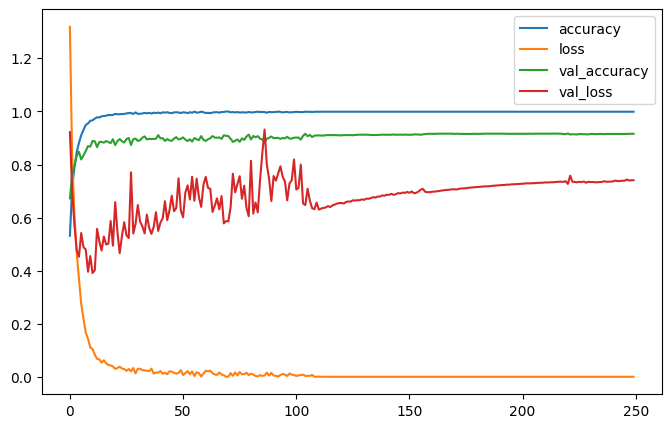

In [ ]:
model = kr.models.Sequential([
    kr.layers.Dense(1024, activation="relu", input_shape=(x_train.shape[1],)),
    kr.layers.Dropout(0,3),

    kr.layers.Dense(512, activation="relu"),
    kr.layers.Dropout(0,3),

    kr.layers.Dense(256, activation="relu"),
    kr.layers.Dropout(0,3),

    kr.layers.Dense(128, activation="relu"),
    kr.layers.Dropout(0,3),

    kr.layers.Dense(64, activation="relu"),
    kr.layers.Dropout(0,3),

    kr.layers.Dense(10, activation="softmax")
])

print(model.summary())
history = train_model(model, 250, "rmsprop")
plot_history(history)

In [ ]:
model.save("/content/drive/MyDrive/Data/genre_model_a.h5")

# Testing the model

In [ ]:
model = kr.models.load_model("/content/drive/MyDrive/Data/genre_model_a.h5")

test_audio = "/content/drive/MyDrive/Data/genres_original/jazz/jazz.00003.wav"

def extract_features(audio_path, sr = sample_rate, n_mfcc=57, n_fft=2048, hop_length=512):
  y, sr = librosa.load(audio_path, sr=sr)
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
  mfccs = np.mean(mfccs.T, axis=0)
  return mfccs

features = extract_features(test_audio)

features = features.reshape(1, -1)

prediction_class = model.predict(features)
prediction_class_label = np.argmax(prediction_class, axis=1)

class_labels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

predicted_genre = class_labels[prediction_class_label[0]]

print(f"The predicted genre is {predicted_genre}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
The predicted genre is jazz


In [ ]:
IPython.display.Audio("/content/drive/MyDrive/Data/genres_original/jazz/jazz.00003.wav", rate=sample_rate)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


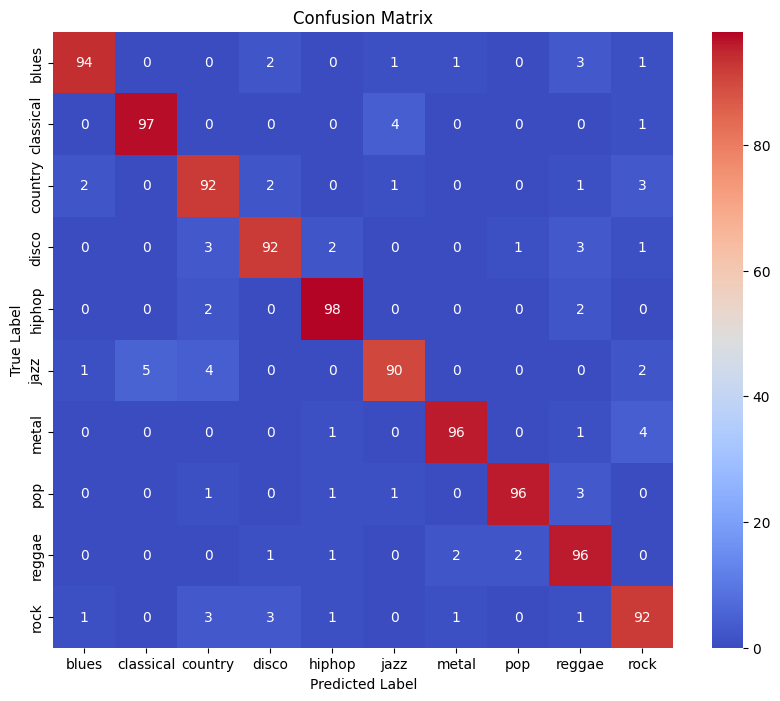

In [ ]:

# Assuming you have y_test and predictions from your model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
confusion_mtx = skm.confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
